# Q-Learning by Neural Network - Maze Runner

This is an example code of q-learning using neural network. The agent needs to run through a 5 x 5 maze via the shortest route, avoiding obstacles and arriving at the goal. It will be punished for a wrong action selected (steping on the obstacles) and rewarded for a correct action (arriving at the goal).

Tensorflow is used for this example.

## Initialization (Import packages and class)

In [0]:
# Import necessary packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Properties of the agent, environment (the maze) and the reward signal (reward map)
class RLAgent(object):
    def __init__(self, ini_state):
        self.state_map = np.arange(25).reshape((5,5))
        self.current_state = ini_state
        self.current_y, self.current_x = self.__findIndex()
        self.reward_map = self.__createRewardMap()

    # if a step (action) is taken by the agent, current state will be incremented, also, its location in the state_map will change
    def step(self, action):
        self.previous_state = self.current_state
        if action == "u" or action == 0:
            self.current_y -= 1
        elif action == "d" or action == 1:
            self.current_y += 1
        elif action == "l" or action == 2:
            self.current_x -= 1
        elif action == "r" or action == 3:
            self.current_x += 1
        elif action == "s":
            print("goal arrived")
        self.current_state = self.state_map[self.current_y, self.current_x]
    def __findIndex(self):
        indexes = np.where(self.state_map == self.current_state)
        return int(indexes[0]), int(indexes[1])
    
    # Return the current location of the agent as x,y cooridinate in the state_map
    def getCoor(self):
        return (self.current_y, self.current_x)
    
    # The agent cannot step outside of the map boundary, therefore, at the boundary the choices of next action are controlled
    def getNextDirection(self):
        if self.current_state in [1,2,3]:
            return ("d", "l", "r")
        elif self.current_state in [5,10,15]:
            return ("u", "d", "r")
        elif self.current_state in [9,14,19]:
            return ("u", "d", "l")
        elif self.current_state in [21,22,23]:
            return ("u", "l", "r")
        elif self.current_state == 0:
            return ("r", "d")
        elif self.current_state == 4:
            return ("l", "d")
        elif self.current_state == 20:
            return ("u", "r")
        elif self.current_state == 24:
            return ("l", "u")
        else:
            return ("u", "d", "l", "r")

    @staticmethod
    def __createRewardMap():
        reward_points = [(0,1), (1,1), (2,1), (2,3), (3,3), (4,3), (4,4)]
        reward_map = np.zeros((5,5))
        for point in reward_points:
            if point != (4,4):
                reward_map[point] = -2500
            else:
                reward_map[point] = 500
        return reward_map



## State Map and Reward Map  
The current state of the agent represents its current location in the _5_ _x_ _5_ maze. The states are indexed by numbers from 0 to 24, corresponding to 25 positions in the maze (as shown in the "state map" below). The states are also indexed by numpy array indexes, for example, state 13 = state_map [ 2 , 3 ].

During calculation, we use a 25 x 25 state matrix to contain the 25 one-hot column vectors, each representing the $n_{th}$  state with value of 1 at the $n_{th}$ row.

In the reward map, the value represents the reward obtained by the agent after it selects an action and steps on there. The negative reward (punishment) represents the **_wall_** that the agent should not pass through, while the positive reward represents the **_goal_** that the agent needs to arrive.


In [130]:
test_agent = RLAgent(0)
print("State Map")
print(np.arange(25).reshape(5,5))
print("Reward Map")
print(test_agent.reward_map)

State Map
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
Reward Map
[[    0. -2500.     0.     0.     0.]
 [    0. -2500.     0.     0.     0.]
 [    0. -2500.     0. -2500.     0.]
 [    0.     0.     0. -2500.     0.]
 [    0.     0.     0. -2500.   500.]]


## Training

Procedures are as follows:

1. Hyper-parameters initialization
2. Creating computational graph by Tensorflow
3. Training

For ease of observation, actions are represented as strings ( "u" = up, "d" = down... and so on ), and they are converted to indexes (0, 1, 2, 3 ) during computation.

Five hyperparameters are tuned. Learning rate, number of episode, number of iteration, $\gamma$ (gamma), probability of randomly sampling an action (e).


In [104]:

# Each key represents a direction the agent is going. 
# "u" = moving up, "d" = down, "l" = left, "r" = right
# The output Q (4 x 1 Matrix) is defined as Q value for each action (totally 4 actions)
# Two dictionaries are used to map between indexes of Q and the action keys
key_to_index = {"u": 0, "d": 1, "l":2, "r":3}
index_to_key = {0:"u", 1:"d", 2:"l", 3:"r"}

# One-hot vector for each state. Each state represents one unique position in the grid
state_matrix = np.zeros((25,25))
for i in range(25):
    state_matrix[i, i] = 1

# Hyperarameters (fine tuned for this project)
learning_rate = 0.00001
num_episode = 500
num_iter = 100
gamma = 0.9
e = 0.7
e_initial = e

# Network Parameters
n_hidden_1 = 256 
num_states = 25 
num_actions = 4

def createParameters():
    weights = {
        'h1': tf.Variable(tf.random_normal([n_hidden_1, num_states])),
        'out': tf.Variable(tf.random_normal([num_actions, n_hidden_1]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1,1])),
        'out': tf.Variable(tf.random_normal([num_actions,1]))
    }
    return weights, biases

def forwardProp(x, weights, biases):
    
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(weights['h1'], x), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(weights['out'], layer_1) + biases['out']
    return out_layer

# Construct model & Output
weights, biases = createParameters()
X_input = tf.placeholder(shape=[num_states, 1], dtype=tf.float32)
Q_next_state = tf.placeholder(shape=[num_actions, 1],dtype=tf.float32)
Qout = forwardProp(X_input, weights, biases)

# Find the index of the action which has the highest score in output matrix Q
first_action = tf.argmax(Qout,0)

# Define loss and optimizer
loss = (1/num_actions)*tf.reduce_sum(tf.square(Q_next_state - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
updateWeights = trainer.minimize(loss)

# Initialize the variables
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Record Cost
cost_list_iter = []
cost_list_episode = []

# ----------------- Start Training -----------------

# There are num_episode of games. Each time the agent state is reset to 0 (starting point)
for j in range(num_episode):
    agent = RLAgent(0)
    
    # Each game episode is iterated for num_iter times
    for i in range(num_iter):
        
        # Feedforward to the network, and output the action choices (the scores of all actions) and the first choice
        first_Q_idx, Q1 = sess.run([first_action, Qout],feed_dict={X_input:state_matrix[:,agent.current_state].reshape((25,1))})
        
        # Define the best action at the current state
        first_Q_idx = first_Q_idx[0]
        first_Q_key = index_to_key[first_Q_idx]
        
        # agent.getNextDirection() returns the allowed direction of step at the current state, such that it will not step outside of the 5 x 5 matrix map
        next_direction = agent.getNextDirection()
        
        # There is e chance that the agent will step in a random direction
        # The condition on the right is to ensure the best action "first_Q_key" is in the allowed choices
        if np.random.rand(1) < e or (first_Q_key not in next_direction):
            
            # Select randomly from the set of allowed directions
            rand_index = np.random.randint(0, len(next_direction))
            Q_index = key_to_index[next_direction[rand_index]]
        else:
            
            # Select the best action (with highest Q value)
            Q_index = first_Q_idx

        # Agent goes to the next state based on the selected action above
        agent.step(Q_index)
        
        # Get the reward at the current state. Reward < 0 when the path is undesirable, and vice versa
        coordinates = agent.getCoor()
        reward = agent.reward_map[coordinates[0], coordinates[1]]
        
        # Calculate the ouput Q-matrix for the next state
        Q2 = sess.run(Qout,feed_dict={X_input:state_matrix[:,agent.current_state].reshape((25,1))})
        
        # Subsitute the current Q value of the selected action with the best Q value of the next state, with discount of gamma <= 1
        Q_target = Q1
        Q_target[Q_index,0] = reward + gamma * np.max(Q2)
        
        # Update the weights by back propagation. 
        # Since the state has been incremented, we backpropagate the "previous_state" remembered by the agent object instead
        _,loss_val = sess.run([updateWeights,loss],feed_dict={X_input:state_matrix[:,agent.previous_state].reshape((25,1)),Q_next_state:Q_target})
        cost_list_iter.append(loss_val)
        
        # Print the progress if you want
        print("\r Iter/Episode = %d/%d" % (i, j), end = "")
        # print("Iter/Episode = %d/%d | state = %d | Loss = %f" % (i, j, agent.current_state, loss_val))
    
    # Record the cost
    if len(cost_list_iter) != 0:
        cost_list_episode.append(np.mean(cost_list_iter))
        cost_list_iter = []


 Iter/Episode = 99/499

## Testing the agent

After the training above, the agent will start to navigate through the maze and try to avoid the wall. It will stop when it arrive the goal. 



In [105]:
print("\nTesting phase starts")

# Reset the agent to the state of 0 (top-left corner)
agent = RLAgent(0)

# Record the action sequence
action_sequence = []

for i in range(50):
    print("Current state = ", agent.current_state)
    if agent.current_state == 24:
        print("Goal arrived! Game ends.")
        break
        
    # Forward propagate and get the output Q values
    Q_values = sess.run(Qout,feed_dict={X_input:state_matrix[:,agent.current_state].reshape((25,1))})
    
    # Sort the values of Q, such that it contains the indexes of actions by a descending order of scores
    Q_sorted = np.flip(np.argsort(Q_values.squeeze()),axis = 0)
    
    # Get the allowed directions in the current state
    next_direction = agent.getNextDirection()
    
    # initalise the varible that will store the best action we take
    action_key = 99
    
    # We check each action in Q_sorted and see if it is in one of the allowed directions.
    # The action with higher Q-value will be checked first, once we know it is in the allowed directions, we select that action and exit the loop
    for j in Q_sorted:
        
        # Once an action is selected, exit the loop
        if action_key != 99:
            break
            
        # If the action is in the allowed direction, store it into action_key
        if index_to_key[j] in next_direction:
            action_key = index_to_key[j]
            
        # If not, then check the next action
        else:
            continue
            
    # Showing Q-matrix and how the agent select the action
#     print("Q_val = %s | Q_sorted = %s | Action_selected = %s | Allowed_direction  = %s" % (str(Q_values.squeeze()), str(Q_sorted), action_key, str(next_direction)))

    # Increment the state and record the action
    action_sequence.append(action_key)
    agent.step(action_key)
sess.close()



Testing phase starts
Current state =  0
Current state =  5
Current state =  10
Current state =  15
Current state =  16
Current state =  17
Current state =  12
Current state =  7
Current state =  8
Current state =  9
Current state =  14
Current state =  19
Current state =  24
Goal arrived! Game ends.


The steps that the agent has taken are recorded and ploted in the scatter graph beblow, which shows the starting point (star), available steps (yellow squares), obstacles (black squares), goal (red square) and the step trace taken by the agent (blue circles). 

It shows that the agent was successfully trained to escape the obstacles (black squares) and find the fastest route to the goal (red square).

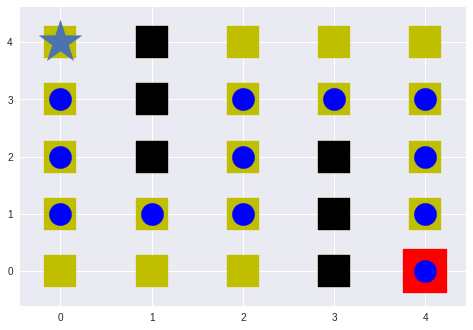

In [128]:
# Drawing the reward map and the wall
all_points = np.array([(x,y) for x in range(5) for y in range(5)])
punish_points = np.array([(0,1), (1,1), (2,1), (2,3), (3,3), (4,3)])
reward_points = np.array((4,4))
plt.scatter(all_points[:,1], 4-all_points[:,0], s=1000, marker = "s", c= "y")
plt.scatter(punish_points[:,1], 4-punish_points[:,0], s=1000, marker = "s", c= "k")
plt.scatter(reward_points[1], 4-reward_points[0], s=2000, marker = "s", c = "r")
plt.scatter(0, 4, s = 2000, marker = "*")

# Drawing the trajectory
test_agent = RLAgent(0)
coor_list = []
for key in action_sequence:
    test_agent.step(key)
    coor_list.append(test_agent.getCoor())
trajectory = np.array(coor_list)
plt.scatter(trajectory[:,1], 4-trajectory[:,0], s = 500, c = "b")


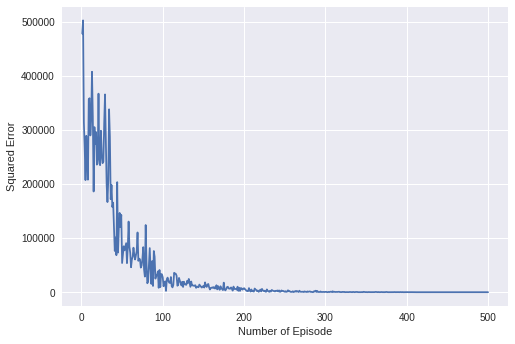

In [106]:
# Plotting the cost along the episode

t_episode = np.arange(len(cost_list_episode)) + 1
plt.plot(t_episode, cost_list_episode)
plt.xlabel("Number of Episode")
plt.ylabel("Squared Error")
plt.show()

## Observations

1. Reward of the goal has to be larger if it requires many time steps to arrive. This can be illustrated by reducing the reward of the goal (e.g. 100, while maintaing its ratio with the punishment), the agent will fail to find the goal while circulating around the initial local area (because the goal reward is too far away and cannot influence the Q value of initial state)

2. Punishment (negative reward) has to be large for undesired path (e.g. 5 times more than the goal's). Otherwise the agent will choose the undesired path rather than a long detour (e.g. 22 -> 23 -> 24, rather than 22 -> 17 -> 12 -> 7 -> 8 -> 9 -> 14 -> 19 -> 24). Because positive reward is less discounted in fewer time steps. This problem can be illustrated by reducing the ratio of punichment to goal's reward, e.g. from (-2500,500) to (-500,500). In this case, the agent will pass the undesired route with punishment.

3. The above two problems can be tuned by the hyperparameter of "gamma" (discount of future reward)

4. Actions are chosen by the agent either randomly or greedily (the action highest predicted reward is chosen). Randomness of choosing an action during training (hyperparameter "e", the probaility of random sampling, as opposed to greedy sampling) could greatly influence the training. 
    * If e is too low (e ~ 0), the agent will always choose an action solely based on its prediction. As a result, the agent may stuck in some infinite loop, bouncing back between two states, when the Q-values have not yet converaged and they temporarily indicate that the best action at one of the two states is to go to the another state. 
    * The purpose of higher e in this case is to break away from this infinite loop. On the other hand, if e is too high (e ~ 1), the agent always choose an action randomly, and it may take longer time to reach the goal and require more iterations (slowing down the training).

5. Ideally, the hyperparameter e should be replaced by some designed strategy to choose an action during training. The strategy should allow the coveragence of interested states and the reach of goal. 
    * Possible approach # 1: At each state, retrieve the past memory of how many times the actions have been taken, and then choose the one with fewer times. 
    * Possible approach # 2:  Algorithmicall design the agent to break the loop if it repeats the route too many times.





